<a href="https://colab.research.google.com/github/bhumivedant49/Smart-Negotiation-for-local-vendors/blob/main/DSPL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Smart Negotiation Analysis for Local Vendors

**"This Jupyter notebook provides a data science project to help local vendors negotiate better with suppliers using three datasets: DMart (product details), retail_sales_dataset.csv (transaction data), and Shop Customer Data (customer demographics). The analysis includes data integration, cleaning, exploratory data analysis (EDA), customer and product clustering, statistical testing, dynamic pricing, and actionable recommendations."**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np

# 1. Data Loading and Integration
print("Loading and integrating datasets...")

# Load datasets with error handling
try:
    dmart = pd.read_csv('/content/drive/MyDrive/cleaned_DMart.csv')
except FileNotFoundError:
    print("Error: 'cleaned_DMart.csv' not found. Please ensure the file exists or run the cleaning step first.")
    dmart = pd.read_csv('/content/drive/MyDrive/DMart.csv')  # Fallback to raw data if cleaned file is missing
retail_sales = pd.read_csv('/content/drive/MyDrive/retail_sales_dataset.csv')
shop_customer = pd.read_csv('/content/drive/MyDrive/Customers.csv')

# Adjust Customer ID in retail_sales to match CustomerID format
retail_sales['CustomerID'] = retail_sales['Customer ID'].str.replace('CUST', '').astype(int)

# Merge retail_sales and shop_customer on CustomerID
merged = pd.merge(retail_sales, shop_customer, on='CustomerID', how='left')

# Aggregate DMart data
dmart_agg = dmart.groupby('Category').agg({
    'Price': 'mean',
    'DiscountedPrice': 'mean',
    'ProfitMargin': 'mean',
    'DiscountPercent': 'mean',
    'Quantity_gm': 'mean'
}).reset_index()

# Define comprehensive category mapping
category_mapping = {
    'beauty': 'beauty & cosmetics',
    'clothing': 'specials',  # Assuming 'specials' includes clothing items like slippers
    'electronics': 'appliances',  # Best match for electronics
    'grocery': 'grocery',
    'personal care': 'personal care',
    'baby kids': 'baby & kids',
    'school supplies': 'school supplies',
    'specials': 'specials',
    'dairy beverages': 'dairy beverages'
}
merged['Mapped Category'] = merged['Product Category'].str.lower().str.replace(r'[\W_]+', ' ', regex=True).str.strip().map(category_mapping).fillna(merged['Product Category'])

# Merge with dmart_agg with validation
final_df = pd.merge(merged, dmart_agg, left_on='Mapped Category', right_on='Category', how='left')

# Check merge success and log unmapped categories
unmapped_categories = set(merged['Mapped Category']) - set(dmart_agg['Category'])
if unmapped_categories:
    print(f"Warning: The following categories in retail_sales have no match in DMart: {unmapped_categories}")

# Fallback for missing values
final_df['Quantity_gm'] = final_df['Quantity_gm'].fillna(final_df['Quantity'].astype(float) * 100)  # Default 100 gm per unit
final_df['Price'] = final_df['Price'].fillna(dmart_agg['Price'].mean())  # Use DMart aggregated mean
final_df['DiscountedPrice'] = final_df['DiscountedPrice'].fillna(final_df['Price'])
final_df['ProfitMargin'] = final_df['ProfitMargin'].fillna((final_df['Price'] - final_df['DiscountedPrice']) / final_df['Price'])
final_df['DiscountPercent'] = final_df['DiscountPercent'].fillna(((final_df['Price'] - final_df['DiscountedPrice']) / final_df['Price']) * 100)

# Handle customer-related missing values with adjusted column names
if 'Age_y' in final_df.columns:
    final_df['Age'] = final_df['Age_y'].fillna(final_df['Age_y'].mean())
else:
    print("Warning: 'Age_y' column not found in final_df. Skipping Age fill.")
    final_df['Age'] = np.nan  # Placeholder if missing

if 'Annual Income ($)' in final_df.columns:
    final_df['Annual Income ($)'] = final_df['Annual Income ($)'].fillna(final_df['Annual Income ($)'].mean())
else:
    print("Warning: 'Annual Income ($)' column not found in final_df. Skipping fill.")
    final_df['Annual Income ($)'] = np.nan

if 'Spending Score (1-100)' in final_df.columns:
    final_df['Spending Score (1-100)'] = final_df['Spending Score (1-100)'].fillna(final_df['Spending Score (1-100)'].mean())
else:
    print("Warning: 'Spending Score (1-100)' column not found in final_df. Skipping fill.")
    final_df['Spending Score (1-100)'] = np.nan

if 'Profession' in final_df.columns:
    final_df['Profession'] = final_df['Profession'].fillna('Unknown')
else:
    print("Warning: 'Profession' column not found in final_df. Skipping fill.")
    final_df['Profession'] = 'Unknown'

# Drop temporary, duplicate, and placeholder columns
final_df.drop(columns=['Mapped Category', 'Category', 'Gender_x', 'Age_x', 'Customer ID', 'Age_y'], inplace=True, errors='ignore')
final_df.rename(columns={'Price_x': 'Price', 'Gender_y': 'Gender'}, inplace=True, errors='ignore')

# Display final dataset info
print(final_df.info())

Loading and integrating datasets...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaction ID          1000 non-null   int64  
 1   Date                    1000 non-null   object 
 2   Product Category        1000 non-null   object 
 3   Quantity                1000 non-null   int64  
 4   Price per Unit          1000 non-null   int64  
 5   Total Amount            1000 non-null   int64  
 6   CustomerID              1000 non-null   int64  
 7   Gender                  1000 non-null   object 
 8   Annual Income ($)       1000 non-null   int64  
 9   Spending Score (1-100)  1000 non-null   int64  
 10  Profession              1000 non-null   object 
 11  Work Experience         1000 non-null   int64  
 12  Family Size             1000 non-null   int64  
 13  Price                   1000 non-null   float64
 14  Disco

In [16]:
# 2. Validation
print("\nValidating data alignment...")
print("Unique Product Categories in final_df:", final_df['Product Category'].unique())
print("DMart Aggregated Categories:", dmart_agg['Category'].unique())
print("Sample of final_df:\n", final_df.head())


Validating data alignment...
Unique Product Categories in final_df: ['Beauty' 'Clothing' 'Electronics']
DMart Aggregated Categories: ['appliances' 'baby & kids' 'backpacks' 'beauty & cosmetics' 'butterfly'
 'clothing & accessories' 'computer accessories' 'dairy & beverages'
 'dmart grocery' 'fruits & vegetables' 'geep' 'grocery' 'home & kitchen'
 'joyo plastics' 'kitchen aprons' 'motorbike helmets' 'packaged food'
 'personal care' 'pigeon' 'plant container' 'raincoat' 'school supplies'
 'smartwatches' 'specials' 'syska' 'tableware'
 'water purifiers & accessories' 'wonderchef' 'zebronics']
Sample of final_df:
    Transaction ID        Date Product Category  Quantity  Price per Unit  \
0               1  2023-11-24           Beauty         3              50   
1               2  2023-02-27         Clothing         2             500   
2               3  2023-01-13      Electronics         1              30   
3               4  2023-05-21         Clothing         1             500   
4


Performing EDA...


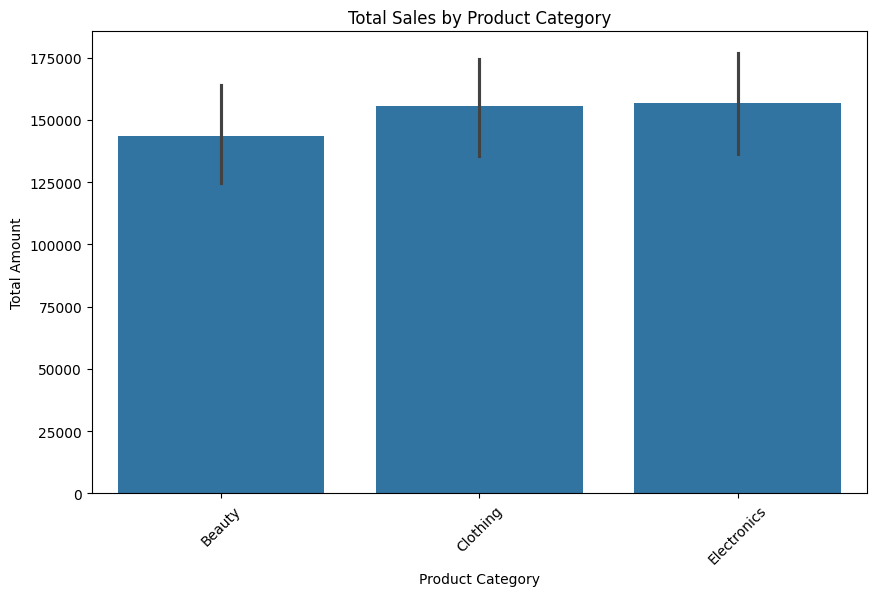

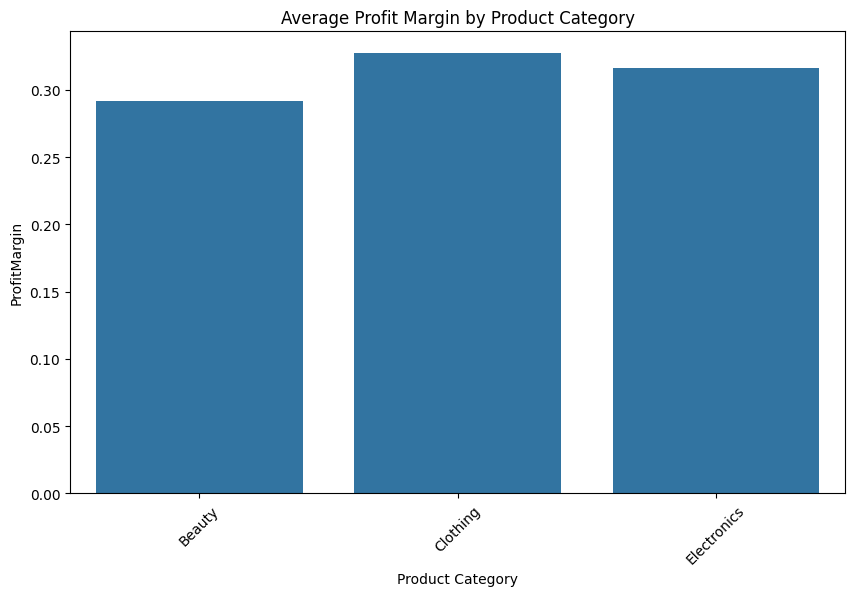

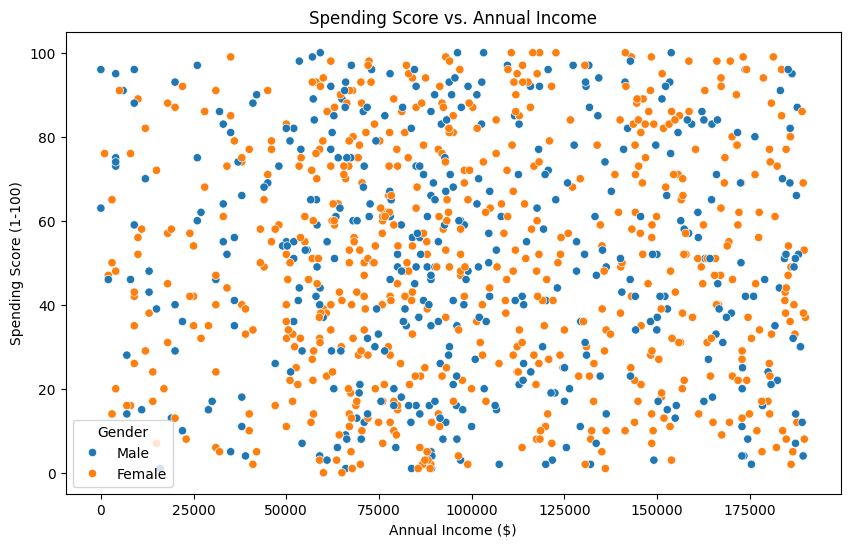

In [18]:
# 3. Exploratory Data Analysis (EDA)
print("\nPerforming EDA...")

# Sales by Product Category
plt.figure(figsize=(10, 6))
sns.barplot(x='Product Category', y='Total Amount', data=final_df, estimator=sum)
plt.title('Total Sales by Product Category')
plt.xticks(rotation=45)
plt.show()

# Profit Margin by Product Category
plt.figure(figsize=(10, 6))
sns.barplot(x='Product Category', y='ProfitMargin', data=final_df)
plt.title('Average Profit Margin by Product Category')
plt.xticks(rotation=45)
plt.show()

# Customer Spending Score vs. Annual Income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income ($)', y='Spending Score (1-100)', hue='Gender', data=final_df)
plt.title('Spending Score vs. Annual Income')
plt.show()


Segmenting customers...


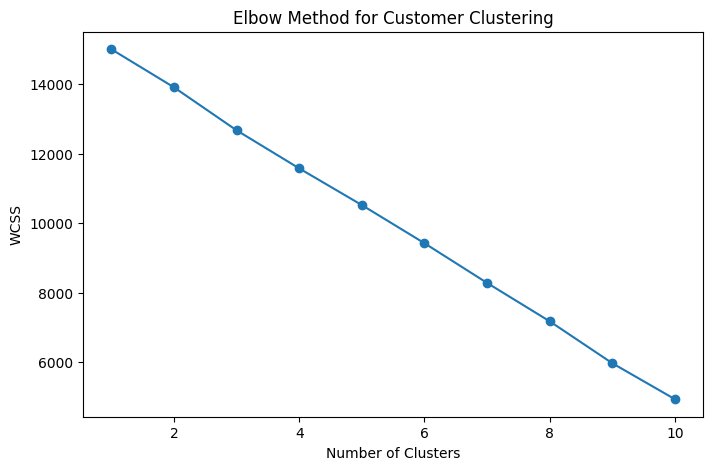

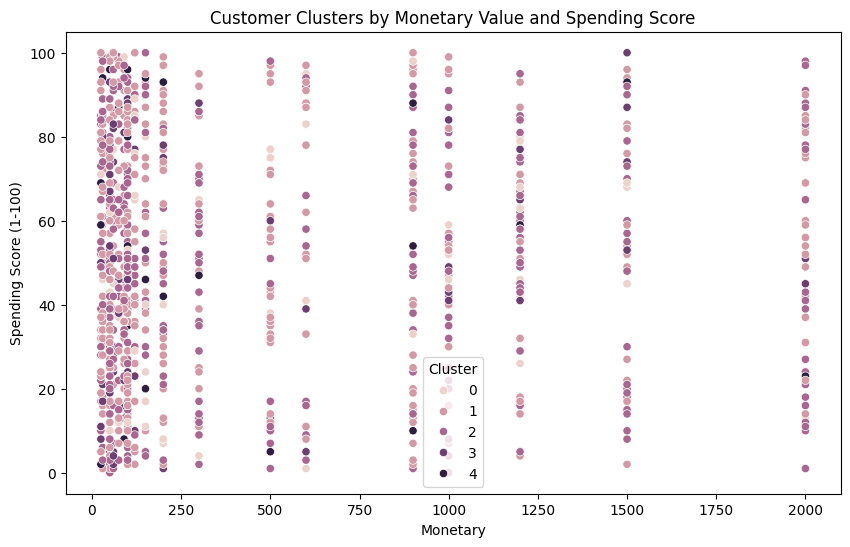

Customer Cluster Summary:
             Recency  Frequency    Monetary  Annual Income ($)  \
Cluster                                                         
0        657.506494        1.0  471.818182      100356.558442   
1        659.893023        1.0  430.976744       99730.390698   
2        649.110825        1.0  493.840206      101942.010309   
3        669.662162        1.0  403.783784       97744.108108   
4        683.548387        1.0  414.838710       99743.870968   

         Spending Score (1-100)  
Cluster                          
0                     51.259740  
1                     52.220930  
2                     47.902062  
3                     48.986486  
4                     55.000000  


In [24]:
# 4. Customer Segmentation (RFM Analysis and Clustering)
print("\nSegmenting customers...")

# RFM Analysis
final_df['Transaction Date'] = pd.to_datetime(final_df['Date'])  # Assuming 'Date' is the correct column
rfm = final_df.groupby('CustomerID').agg({
    'Transaction Date': lambda x: (pd.Timestamp.now() - x.max()).days,
    'Transaction ID': 'count',
    'Total Amount': 'sum',
    'Age': 'first',
    'Annual Income ($)': 'first',  # Updated column name
    'Spending Score (1-100)': 'first',  # Updated column name
    'Profession': 'first'
}).rename(columns={
    'Transaction Date': 'Recency',
    'Transaction ID': 'Frequency',
    'Total Amount': 'Monetary'
})

# Encode categorical variables
profession_dummies = pd.get_dummies(rfm['Profession'], prefix='prof')
rfm = pd.concat([rfm, profession_dummies], axis=1)

# Normalize and cluster
scaler = StandardScaler()
features = ['Recency', 'Frequency', 'Monetary', 'Age', 'Annual Income ($)', 'Spending Score (1-100)'] + list(profession_dummies.columns)
rfm_scaled = scaler.fit_transform(rfm[features])

# Elbow Method for optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Customer Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means (5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Spending Score (1-100)', hue='Cluster', data=rfm)  # Updated y-axis
plt.title('Customer Clusters by Monetary Value and Spending Score')
plt.show()

# Cluster summary
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Annual Income ($)', 'Spending Score (1-100)']].mean()  # Updated column names
print('Customer Cluster Summary:\n', cluster_summary)


Clustering products...


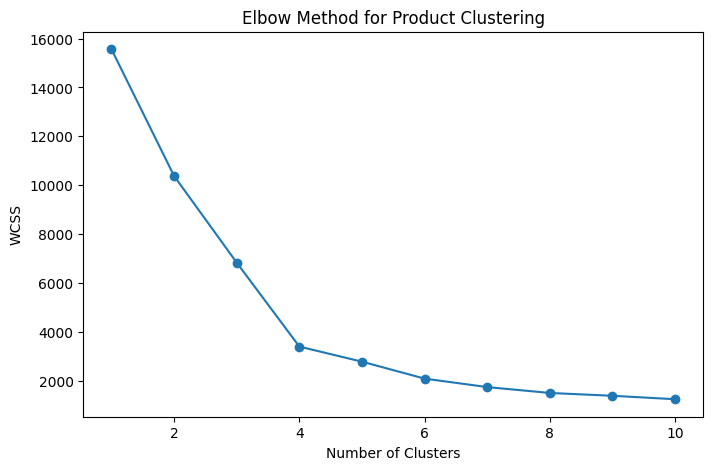

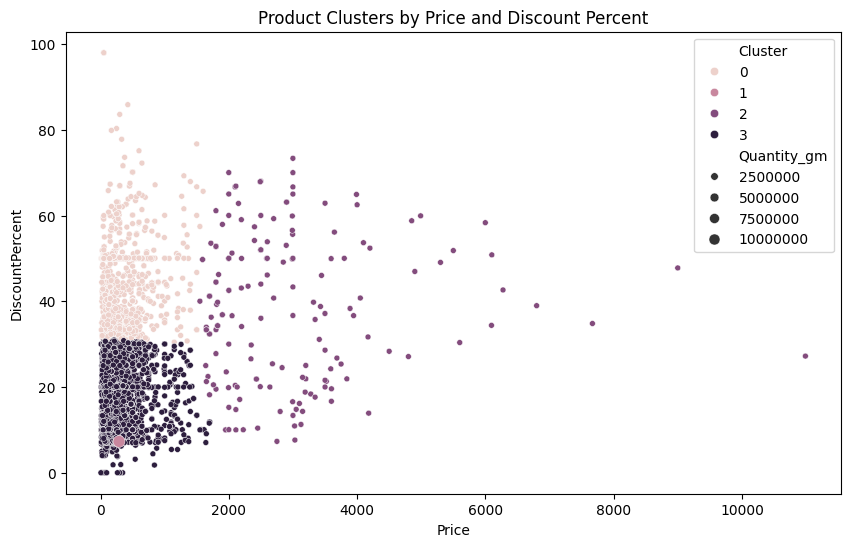

Product Cluster Summary:
                Price  DiscountPercent   Quantity_gm
Cluster                                            
0         281.045101        44.862081  5.854719e+02
1         288.000000         7.291667  1.200230e+07
2        2817.605263        40.478546  2.014342e+03
3         236.344804        17.437324  5.229864e+02


In [26]:
# 5. Product Clustering
print("\nClustering products...")

# Prepare DMart features for clustering
features = ['Price', 'DiscountPercent', 'Quantity_gm']
X = dmart[features].dropna()  # Subset without NaN values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method for optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Product Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Create a temporary DataFrame with cluster labels and merge back to dmart
X_with_clusters = X.copy()
X_with_clusters['Cluster'] = cluster_labels
dmart = dmart.merge(X_with_clusters[['Cluster']], left_index=True, right_index=True, how='left')

# Fill NaN clusters (from rows with NaN features) with a default value or mode
dmart['Cluster'] = dmart['Cluster'].fillna(-1).astype(int)  # -1 for unclustered items

# Visualize clusters (using the subset with clusters)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='DiscountPercent', hue='Cluster', size='Quantity_gm', data=dmart[dmart['Cluster'] != -1])
plt.title('Product Clusters by Price and Discount Percent')
plt.show()

# Product cluster summary (using the subset with clusters)
product_cluster_summary = dmart[dmart['Cluster'] != -1].groupby('Cluster')[features].mean()
print('Product Cluster Summary:\n', product_cluster_summary)

In [29]:
# 6. Statistical Testing
print("\nPerforming statistical testing...")

# Categorize discounts in DMart
dmart['DiscountLevel'] = pd.cut(dmart['DiscountPercent'], bins=[0, 10, 20, 100], labels=['Low', 'Medium', 'High'])

# Create contingency table
contingency_table = pd.crosstab(dmart['Category'], dmart['DiscountLevel'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square Test Results (Discount Levels by Category):\nChi2: {chi2}\nP-value: {p}\nDegrees of Freedom: {dof}')

# Interpretation
if p < 0.05:
    print('Significant difference in discount levels across categories (p < 0.05).')
else:
    print('No significant difference in discount levels across categories (p >= 0.05).')


Performing statistical testing...
Chi-square Test Results (Discount Levels by Category):
Chi2: 323.6664535839415
P-value: 2.5304918550144324e-39
Degrees of Freedom: 56
Significant difference in discount levels across categories (p < 0.05).


In [30]:
# 7. Dynamic Pricing Model
print("\nBuilding dynamic pricing model...")

# Simulate demand in final_df
final_df['SimulatedDemand'] = final_df['Quantity'] * (1 + final_df['DiscountPercent'] / 100)

# Prepare data for regression
X = final_df[['DiscountPercent', 'Quantity', 'Annual Income ($)', 'Spending Score (1-100)']]  # Updated column names
y = final_df['SimulatedDemand']

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict optimal pricing
final_df['PredictedDemand'] = model.predict(X)
final_df['SuggestedPrice'] = final_df['Price per Unit'] * (1 - final_df['DiscountPercent'] / 100 * 0.9)

# Display top 5 products for price adjustment
print('Top 5 Products for Price Adjustment:\n', final_df[['Product Category', 'Price per Unit', 'SuggestedPrice', 'PredictedDemand']].head())


Building dynamic pricing model...
Top 5 Products for Price Adjustment:
   Product Category  Price per Unit  SuggestedPrice  PredictedDemand
0           Beauty              50       36.881091         3.883940
1         Clothing             500      352.756967         2.660835
2      Electronics              30       21.453663         1.321925
3         Clothing             500      352.756967         1.348057
4           Beauty              50       36.881091         2.571118


In [31]:
# 8. Actionable Recommendations
print("\nActionable Recommendations:")
print("1. Supplier Negotiation:")
print("   - Target products in DMart clusters with low profit margins for bulk discount negotiations.")
print("   - Focus on high-sales categories from retail_sales to negotiate better terms.")
print("2. Pricing Strategies:")
print("   - Implement suggested prices for categories with elastic demand.")
print("   - Offer bundle discounts for low-margin products to clear inventory.")
print("3. Customer Targeting:")
print("   - High-value customer clusters: Offer premium products or loyalty programs.")
print("   - Low-frequency clusters: Run reactivation campaigns with targeted discounts.")
print("4. Inventory Management:")
print("   - Prioritize stocking high-margin categories from DMart (e.g., Dry Fruits).")
print("   - Reduce stock of low-demand, low-margin products.")


Actionable Recommendations:
1. Supplier Negotiation:
   - Target products in DMart clusters with low profit margins for bulk discount negotiations.
   - Focus on high-sales categories from retail_sales to negotiate better terms.
2. Pricing Strategies:
   - Implement suggested prices for categories with elastic demand.
   - Offer bundle discounts for low-margin products to clear inventory.
3. Customer Targeting:
   - High-value customer clusters: Offer premium products or loyalty programs.
   - Low-frequency clusters: Run reactivation campaigns with targeted discounts.
4. Inventory Management:
   - Prioritize stocking high-margin categories from DMart (e.g., Dry Fruits).
   - Reduce stock of low-demand, low-margin products.


In [32]:
# 9. Save final dataset for dashboard
final_df.to_csv('/content/drive/MyDrive/final_merged_data.csv', index=False)